In [1]:
%matplotlib widget

import platform
import psutil
import time
from pacti.terms.polyhedra import *
import os
import numpy as np
from contract_utils import *
from generators import *

from p_tqdm import p_map, p_umap
from scipy.stats import qmc

import pickle

This notebook demonstrates generating scenarios by varying the hyper-parameters of specific system functions (`dsn`, `chrg`, `sbo`, `tcm_h`, and `tcm_db`) as described below:

In [2]:
# lower bounds for design hyperparameters
l_bounds = [
    2.0,  # power: min dns cons
    2.5,  # power: min chrg gen
    0.3,  # power: min sbo cons
    0.2,  # power: min tcm_h cons
    0.1,  # power: min tcm_dv cons
    5.0,  # science: min dsn speed
    2.0,  # science: min sbo gen
    1.0,  # nav: min dsn noise
    1.0,  # nav: min chrg noise
    0.5,  # nav: min sbo imp
    1.2,  # nav: min tcm_dv noise
    0.3,  # nav: min tcm_dv progress
]
# upper bounds for design hyperparameters
u_bounds = [
    2.2,  # power: max dns cons
    3.5,  # power: max chrg gen
    0.4,  # power: max sbo cons
    0.3,  # power: max tcm_h cons
    0.2,  # power: max tcm_dv cons
    6.0,  # science: max dsn speed
    8.0,  # science: max sbo gen
    1.2,  # nav: max dsn noise
    1.2,  # nav: max chrg noise
    0.8,  # nav: max sbo imp
    1.4,  # nav: max tcm_dv noise
    0.5,  # nav: max tcm_dv progress
]

We use the Latin Hypercube sampler to generate `n5` random combinations of hyper-parameters. We exploit as much parallelism as available on the machine to generate 5-step scenarios for each combination. The results show that Pacti's operations for constructing contracts scale very well.

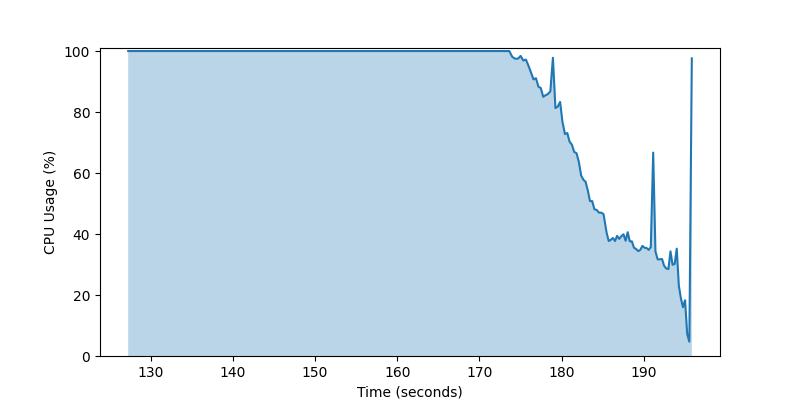

Output()

Generated 200 hyperparameter variations of the 20-step scenario in 195.91573905944824 seconds.
Running on AMD Ryzen Threadripper PRO 3955WX 16-Cores @ 3.8927 GHz with up to 32 threads.
Total count of Pacti operations for each 5-step scenario: 115 contracts, 63 compositions, and 50 merges.


In [3]:
mean_sampler = qmc.LatinHypercube(d=len(l_bounds))
dev_sampler = qmc.LatinHypercube(d=len(l_bounds))

n20 = 200
mean_sample20: np.ndarray = mean_sampler.random(n=n20)
scaled_mean_sample20: np.ndarray = qmc.scale(sample=mean_sample20, l_bounds=l_bounds, u_bounds=u_bounds)
dev_sample20: np.ndarray = dev_sampler.random(n=n20)

nb_20step_operations = OperationCounts(contracts=115, compositions=63, merges=50)

from cpu_usage_plot import *
with cpu_usage_plot(max_data_points = 200):
    ta = time.time()
    scenarios20: List[Tuple[List[tuple2float], PolyhedralContract]] = p_umap(generate_20step_scenario, list(zip(scaled_mean_sample20, dev_sample20)))
    tb = time.time()

print(
    f"Generated {n20} hyperparameter variations of the 20-step scenario in {tb-ta} seconds.\n"
    f"Running on {cpu_info_message}\n"
    f"Total count of Pacti operations for each 5-step scenario: {nb_20step_operations}."
)
s = open("scenarios20.data", "wb")
pickle.dump(scenarios20, s)
s.close()
